# Lecture 6 - Observational Data: Stratifying and Modelling

## Today's Learning Objectives

1. Define a set of variables that control for confounding.
2. Analyze stratified observational data.
3. Interpret regression models fittings for observational data.
4. Supply appropriate caveats for causal claims from fitting regression models to observational data.
5. Comment on the differing goals of regression for prediction versus regression for explanation.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 8, repr.matrix.max.cols = 10)
library(foreign)
library(tidyverse)
library(broom)
library(scales)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘scales’




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor




## Where are we at?

We have been devoting most of our time to randomized experiments (i.e., **A/B** or **A/B/n testing**). This is the ideal setting where we actually have control over the data collection and **treatment randomization**. Moreover, this class of statistical framework certainly allows us **to draw causal conclusions on a given outcome of interest**.

Recall that if we can **randomize experimental units** to the two groups of conditions being compared (e.g, **control treatment A** and **experimental treatment B**), then data analysis and causal interpretation can be clear. Hence, **we can be confident in our A/B testing decisions**. Furthermore, this **treatment randomization** setting will be crucial **to control for confounding variables on a high level**.

For example, **as long as we have an adequate overall sample size (via Power Analysis!) and randomize properly**, we can gather statistical evidence to state that website version B directly **causes** better sales than website version A. Consequently, we will be convinced that a permanent switch to website version B will be profitable.

Why are we allowed to make this class of statements? Because treatment randomization balances out all confounding variables, so that the two groups formed differ **only** in which websitsite they see.

Moreover, suppose all website visitors could hypothetically be labelled as either "fussy" or "easy-to-please." Therefore, it is tremendously unlikely to end up with a much higher proportion of fussy people in the website version A than in B via treatment randomization.

Consequently, excuses like **"A did not win because it was faced with a harder-to-please crowd"** will not stand up.

## 1.  Overview of Observational Studies

We will shift gears to **observational studies**. Unlike randomized experiments, we can only gather data from a population of interest via a proper and representative sample. In observational studies, the researcher **WILL NOT** have control over the variable of interest $X$.

### 1.1. Without randomization, life is much harder!

For instance, if people self-select whether to see the A or B website version (such as one of our examples in {doc}`lecture2_simpson_confounding` where we needed to account for `gender` and `age` in our **TikTok® Simulation** of an observational study), you would really want to measure their fussiness level and use this when analyzing the data. This practice will allow you **to estimate accurate and precise effect estimates of your variable $X$ on the response $Y$**.

In general, **the observational study strategy includes**:

1. To the extent possible, **recording potential confounding variables** as part of the data collection process.
2. Using these potential confounding variables **as part of the data analysis**.
3. Tempering the causal strength of claims in light of the inherent challenges in (1) and (2).

Furthermore, note that (1) implicates a **careful data collection planning**.

```{exercise}
:label: lecture6-q1

**Answer TRUE or FALSE:**

Identifying potential confounding variables is not an integral part of a careful data collection planning in an observational study.

**A.** TRUE

**B.** FALSE
```

### 1.2. Where are observational studies in a Data Science pipeline?  

Observational studies are heavily used in **pharmaco-epidemiology** where we can find massive healthcare databases for population health research. For instance, insurance companies and healthcare systems collect this class of data in the US. 

On the other hand, countries like Canada use their national healthcare system to gather this data. You can check www.popdata.bc.ca for some rough flavour.

In addition to statistical methodology issues, this sort of work heavily involves:

- Database and data wrangling issues (defining and extracting populations/samples/variables).
- Privacy, ethics, and security (you already addressed these matters in **DSCI 541**). For a sense of how high the stakes are on this, you can google "*BC health researchers fired*."

Therefore, we generally have an outcome $Y$ (which could be continuous **OR** discrete) subject to a variable of interest $X$ and many confounders $C_j$ which will vary in their nature: continuous **OR** discrete.

For instance, in a pharmaco-epidemiology problem:

- $Y$ is a binary indicator of **bad disease state** two years after initial diagnosis.
- $X$ is a binary indicator of initiated **drug A** versus **drug B** within three months of initial diagnosis.
- $C_j$ is all sorts of demographic variables and health-status variables.

We aspire to use these observational data to determine what we would see if we could do a randomized trial with this $X$ and $Y$.

```{warning}
Merely addressing whether $X$ is associated with $Y$ **IS NOT HELPFUL ANYMORE**. In the previous pharmaco-epidemiology problem, the relevant policy question is: **would fewer patients reach the bad disease state in a world where all were given drug B compared to a world where all were given drug A?**
```

## 2. The Western Collaborative Group Study Data

As in the case of A/B testing data, pharmaco-epidemiology data is hard to come by! Hence, we will work with a more traditional biostatistics example from [Vitinghoff et al. (2012)](https://gw2jh3xr2c.search.serialssolutions.com/?sid=sersol&SS_jc=TC0000658343&title=Regression%20Methods%20in%20Biostatistics%3A%20Linear%2C%20Logistic%2C%20Survival%2C%20and%20Repeated%20Measures%20Models). This dataset is called the Western Collaborative Group Study (WCGS) data.

The WCGS data is a **prospective cohort study** that recruited **middle-aged men between the ages of 39 and 59 who were employees of ten Californian companies** (this is the population for which we will draw our conclusions!). The data was collected on 3154 subjects between 1960 and 1961.

```{important}
A **prospective cohort study** involves following $n$ subjects over time. Certain confounding variables can group these subjects. Nonetheless, these groups will vary by a certain variable of interest (i.e., the $X$ as a factor-type variable with certain levels of interest). We will assess whether the changes from one level to another in $X$ cause the change of a particular outcome $Y$.
```

### 2.1. Data Wrangling

The data `wcgs.dta` is in Stata format. We will use the function `read.dta()` from `foreign` as a tibble. We will eliminate those rows with missing data via `na.omit()` (missing data will not be the scope of today's lecture!). We end up with $n = 3,101$ subjects.

In [2]:
wcgs <- as_tibble(read.dta("../data/wcgs.dta"))
wcgs <- na.omit(wcgs)
wcgs

age,arcus,behpat,bmi,chd69,⋯,typchd69,uni,weight,wghtcat,agec
<int>,<int>,<fct>,<dbl>,<fct>,⋯,<int>,<dbl>,<int>,<fct>,<fct>
50,1,A1,31.32101,No,⋯,0,0.4860738,200,170-200,46-50
51,0,A1,25.32858,No,⋯,0,0.1859543,192,170-200,51-55
59,1,A1,28.69388,No,⋯,0,0.7277991,200,170-200,56-60
51,1,A1,22.14871,No,⋯,0,0.6244636,150,140-170,51-55
⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮
41,0,B4,25.03378,No,⋯,0,0.27816987,195,170-200,41-45
53,0,B4,25.79944,No,⋯,0,0.95139700,185,170-200,51-55
54,0,B4,23.49076,No,⋯,0,0.57082593,150,140-170,51-55
48,0,B4,30.26990,No,⋯,0,0.08677829,205,> 200,46-50


Our raw data `wcgs` has 22 demographic and health-related variables in total. However, our statistical modelling will focus on the following ones:

- `dibpat`: Dichotomous behaviour pattern, a factor-type variable with two levels (`Type A` and `Type B`).
- `age`: Subject's age in years (a count-type variable).
- `bmi`: Subject's body mass index (BMI) in $\text{kg}/\text{m}^2$ (a continuous-type variable).
- `chol`: Subject's cholesterol levels in $\text{mg}/100 \text{ ml}$ (a continuous-type variable).
- `smoke`: Whether the subject smokes or not, a factor-type variable with two levels (`Yes` and `No`).
- `chd69`: Whether the subject experienced a **coronary heart disease (CHD) event**, a factor-type variable with two levels (`Yes` and `No`).

These variables are stored in `training_data`.

In [3]:
training_data <- wcgs %>%
  select(dibpat, age, bmi, chol, smoke, chd69)
training_data

dibpat,age,bmi,chol,smoke,chd69
<fct>,<int>,<dbl>,<int>,<fct>,<fct>
Type A,50,31.32101,249,Yes,No
Type A,51,25.32858,194,Yes,No
Type A,59,28.69388,258,No,No
Type A,51,22.14871,173,No,No
⋮,⋮,⋮,⋮,⋮,⋮
Type B,41,25.03378,180,No,No
Type B,53,25.79944,167,No,No
Type B,54,23.49076,242,Yes,No
Type B,48,30.26990,288,No,No


### 2.2. Main Statistical Inquiry

We are interested in the following: **does a `Type A` behaviour pattern (`dibpat`) LEAD to a CHD event (`chd69`)?** From [Brand et al. (1976)](https://www.ahajournals.org/doi/pdf/10.1161/01.CIR.53.2.348), the levels of `dibpat` are defined as follows:

> *Methods for the assessment of the dichotomous behavior pattern by a structured psychological interview in the
WCGS have been described elsewhere. **Type A** behavior is characterized by enhanced aggressiveness and competitive drive, preoccupation with deadlines, and chronic impatience and sense of time urgency, in contrast with the more relaxed and less hurried **Type B** behavior pattern.*

Hence, we have an $X$ variable, a $Y$ variable, and different potential $C_j$ variables. Which variables are we focusing on?

- $Y$ is binary indicator of coronary heart disease (`chd69`).
- $X$ is binary indicator of `Type A` behaviour (`dibpat`).

### 2.3. Exploratory Data Analysis

Before proceeding with the statistical analysis, let us do a quick exploratory data analysis (EDA). Since we have two binary variables of interest, **stacked bar charts by proportions** are a suitable choice. The plot shows a slight increase in CHD in `Type A` behaviour (at least graphically!). Nevertheless, as usual, we need to dig deeper into the data via some suitable regression model!

In [4]:
options(repr.plot.height = 8, repr.plot.width = 14)

wcgs_prop_summary <- as.data.frame(xtabs(
  ~ dibpat + chd69,
  training_data
) / rowSums(xtabs(
  ~ dibpat + chd69,
  training_data
)), responseName = "prop")

wcgs_data_stacked_bars <- ggplot(wcgs_prop_summary, aes(x = dibpat, y = prop, fill = chd69)) +
  geom_bar(stat = "identity", width = 0.7, colour = "black", linewidth = 0.1) +
  geom_text(aes(label = ifelse(prop >= 0.05, paste0(sprintf("%.0f", prop*100),"%"),"")),
            position = position_stack(vjust = 0.5), colour = "firebrick3", fontface = "bold", size = 6) +
  scale_y_continuous(labels = percent_format()) +
  labs(y = "Percentage", x = "Dichotomous Behavior Pattern", fill = "") +
  ggtitle("Stacked Bar Charts")  +
  theme(plot.title = element_text(size = 24, face = "bold"),
        axis.text.x = element_text(size = 17, angle = 0),
        axis.text.y = element_text(size = 17, angle = 0),
        axis.title = element_text(size = 21),
        legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")), 
        legend.title = element_text(size = 21, face = "bold")) +
  guides(fill = guide_legend(title = "Coronary Heart Disease Event")) + scale_fill_brewer(palette = "Blues")

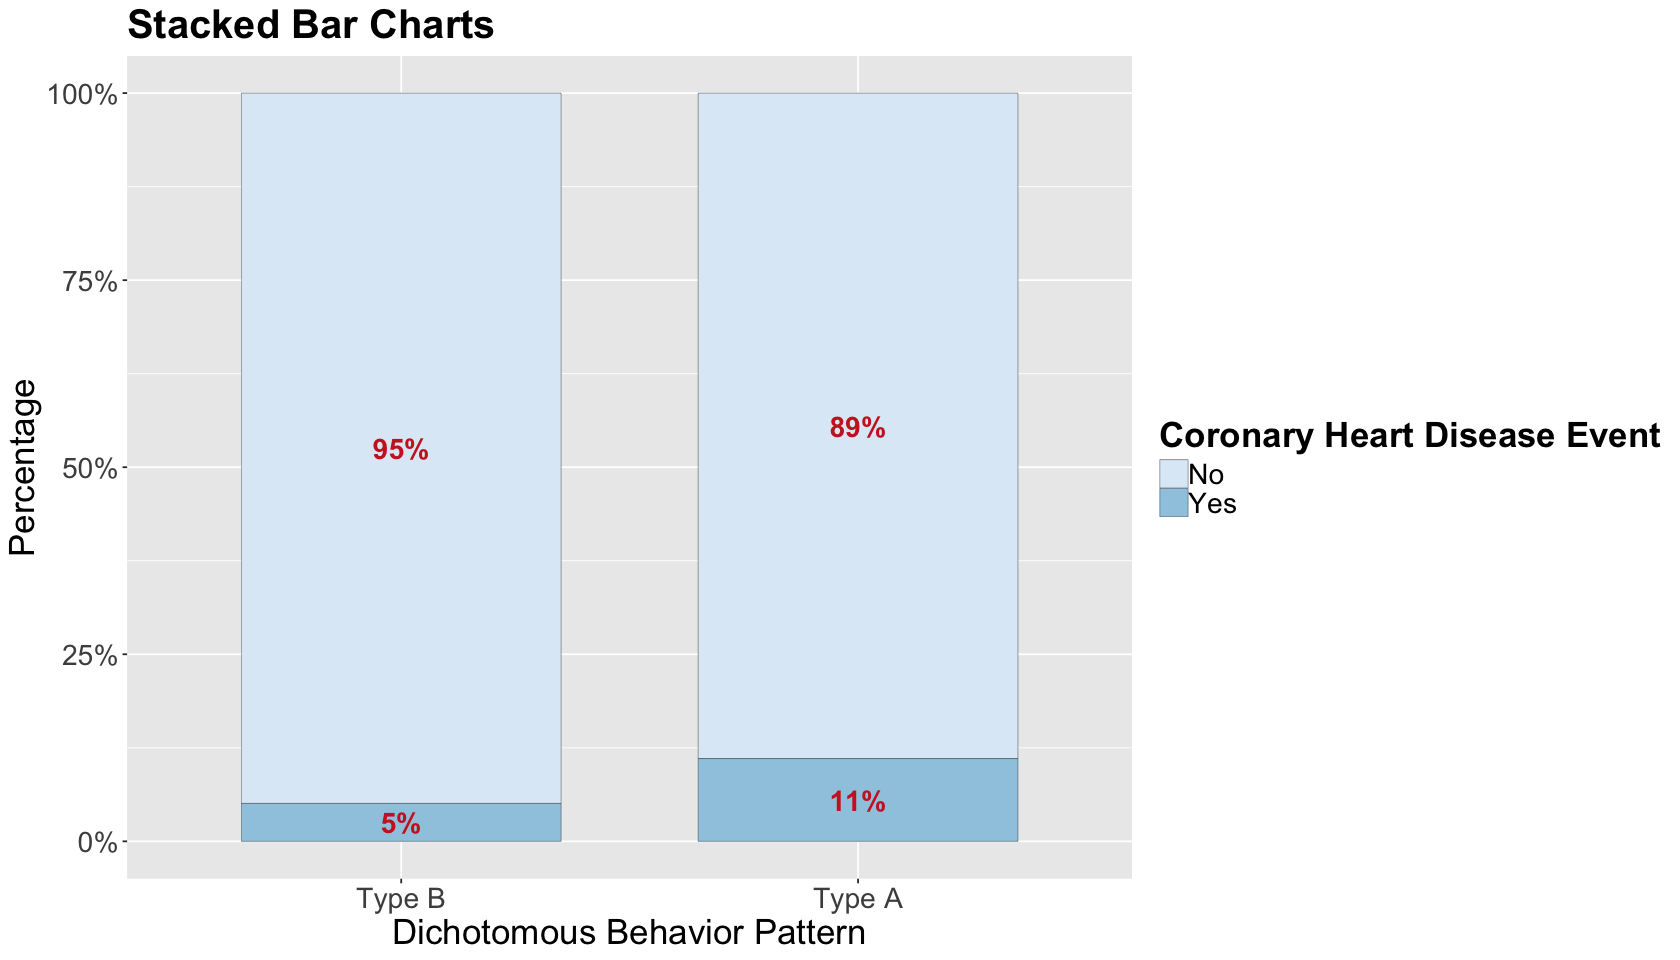

In [5]:
wcgs_data_stacked_bars

## 3. Key Statistical Concepts

Let us mathematically define $Y$ and $X$ as an initial setup. Then, for the $i$th subject, the response `chd69` is defined as:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th subject experienced a CHD event},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

The variable `dibpat` is defined as:

$$
X_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th subject has a Type A behaviour pattern},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

Once we have defined these variables of interest, let us continue with some key statistical concepts.

### 3.1. Log-odds

Recall the "1" category in $Y_i$ is referred as *success*. Note each $Y_i$ is a Bernoulli trial whose probability of success is $\pi_i$, i.e., $Y_i \sim \text{Bernoulli}(\pi_i)$. We are already familiar with the **log-odds**:

$$
\log\left( \frac{\pi_i}{1 - \pi_i}  \right).
$$

This is the **natural logarithm** of the **ratio of the probability of the event to the probability of the non-event** (i.e., the **odds**!) in $Y_i$. Moreover, **in Binary Logistic regression**, our regression coefficients can be interpreted in terms of the **log-odds**.

```{important}
The **log-odds** is to binary variables what correlation is to continuous variables.
```

### 3.2. Estimator of the Log-Odds for One Group

In a simple case with a sample size $n$, if we just have one variable (e.g., **CHD or not**), we can estimate the log-odds by just taking the logarithm of the ratio of the number of patients with CHD to those without CHD:

$$
\text{log-odds} = \log\left( \frac{n_{\text{yes}}/n}{n_{\text{no}}/n} \right) = \log\left( \frac{n_{\text{yes}}}{n_{\text{no}}} \right).
$$

### 3.3. Estimator of the Log-Odds Ratio for Two Groups

Now, let us add the variable $X$ to our statistical metrics besides the outcome $Y$. Suppose both $X$ and $Y$ are binary variables. Then, the **absolute frequencies** by each combination of factor levels can be put in a **contingency table** as follows: 

|  |  $Y = 1$ |  $Y = 0$ |
|:--------------------------------------------------------------------------------------------:|:------------------:|:----------------------:|
|                                   $X = 1$                                   |       $n_{X = 1, Y = 1}$     |      $n_{X = 1,Y = 0}$     |
|                                       $X = 0$                                       |    $n_{X = 0, Y = 1}$    |         $n_{X = 0, Y =0}$        |

```{attention}
A **contingency table** (i.e., cross-tabulation) is merely a way to summarize the absolute frequencies between two categorical variables.
```

The **odds ratio (OR)** measures the **association/causation** between the binary **exposure variable** $X$ and the binary **outcome** $Y$. It will indicate the **odds** that the outcome $Y$ will happen **given** that the exposure $X$ is **present** compared to the **odds** the outcome $Y$ will happen if the exposure $X$ is **absent**. It can be represented as follows:

$$\text{OR} = \frac{\frac{n_{X = 1, Y = 1}/ n}{n_{X = 1,Y = 0} / n}}{\frac{n_{X = 0, Y = 1}/ n}{n_{X = 0,Y = 0} / n}} = \frac{\frac{n_{X = 1, Y = 1}}{n_{X = 1,Y = 0}}}{\frac{n_{X = 0, Y = 1}}{n_{X = 0,Y = 0}}} = \frac{n_{X = 1, Y = 1} \times n_{X = 0,Y = 0}}{n_{X = 1,Y = 0} \times n_{X = 0, Y = 1}}.$$

The OR can be interpreted as follows:

- $\text{OR} = 1$ indicates the binary exposure $X$ **DOES NOT AFFECT** the odds of the binary outcome $Y$.
- $\text{OR} > 1$ indicates the binary exposure $X$ **IS ASSOCIATED WITH** (**OR CAUSES!**) **higher odds** of the binary outcome $Y$.
- $\text{OR} < 1$ indicates the binary exposure $X$ **IS ASSOCIATED WITH** (**OR CAUSES!**) **lower odds** of the binary outcome $Y$.

Analogously to the estimator of the log-odds for one group, we can also have an estimator of the log-OR as follows:
    
$$\hat{\text{log-OR}} = \log \left( \frac{\frac{n_{X = 1, Y = 1}}{n_{X = 1,Y = 0}}}{\frac{n_{X = 0, Y = 1}}{n_{X = 0,Y = 0}}} \right) = \log \left( \frac{n_{X = 1, Y = 1}}{n_{X = 1,Y = 0}} \right) - \log \left( \frac{n_{X = 0, Y = 1}}{n_{X = 0,Y = 0}} \right)$$ 
$$\hat{\text{log-OR}} = \log(n_{X = 1, Y = 1}) - \log(n_{X = 1,Y = 0}) - \big[ \log(n_{X = 0, Y = 1}) - \log(n_{X = 0,Y = 0}) \big].$$

This estimator is **approximately Normal** with a large enough sample size $n$. Its standard error (SE) is:

$$\text{SE} = \sqrt{\frac{1}{n_{X = 1, Y = 1}} + \frac{1}{n_{X = 1,Y = 0}} + \frac{1}{n_{X = 0, Y = 1}} + \frac{1}{n_{X = 0, Y =0}}}.$$

We can set up the following `R` functions with a contingency `table` as an input following the previous formulas. The last function, `logOR_z`, is the test statistic `logOR_z` associated to the hypothesis:

$$H_0\text{: log-OR} = 0$$
$$H_a\text{: log-OR} \neq 0$$

Failing to reject $H_0$ gives statistical evidence that the binary exposure $X$ **DOES NOT AFFECT** the odds of the binary outcome $Y$ with a significance level $\alpha$.

In [6]:
logOR_est <- function(table) {
  log(table[2, 2]) - log(table[2, 1]) - (log(table[1, 2]) - log(table[1, 1]))
}

logOR_se <- function(table) {
  sqrt(sum(1 / table))
}

logOR_z <- function(table) {
  logOR_est(table) / logOR_se(table)
}

### 3.4. Applying the log-OR to the WCGS Case

Let us apply the concept of the log-OR to our training data for our two target variables: the exposure $X$ called behaviour pattern (`dibpat`) and the outcome $Y$ called CHD event (`chd69`). Function `table()` computes the corresponding contingency tables.

In [7]:
cont_table <- table(training_data$dibpat, training_data$chd69)
cont_table

        
           No  Yes
  Type B 1459   78
  Type A 1391  173

Then, we use the function `logOR_est()`.

In [8]:
round(logOR_est(cont_table), 3)

[1] 0.844

We can obtain the interpretation of the OR by exponentiating the log-OR.

An $OR > 1$ indicates the `Type A` behaviour pattern **IS ASSOCIATED WITH** (**OR POSSIBLY CAUSES!**) **higher odds** of having a CHD event.

In [9]:
round(exp(logOR_est(cont_table)), 3)

[1] 2.326

We will also obtain the corresponding SE and test statistic associated with the estimated log-OR.

In [10]:
round(logOR_se(cont_table), 3)

[1] 0.141

In [11]:
round(logOR_z(cont_table), 3)

[1] 5.969

Finally, it can be proved that the previous estimated log-OR, SE, and test statistic can be obtained with a **Binomial Logistic regression model with a single binary regressor $X$**. We fit this model and call it `initial_bin_log`.

In [12]:
initial_bin_log <- glm(chd69 ~ dibpat, data = training_data, family = binomial)
tidy(initial_bin_log, conf.int = 0.95) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.929,0.116,-25.203,0,-3.165,-2.708
dibpatType A,0.844,0.141,5.970,0,0.571,1.126


```{exercise}
:label: lecture6-q2

Can we infer causality between `dibpat` and `chd69` with this `initial_bin_log`?

**A.** Yes.

**B.** No.
```

## 4. Stratified Analysis for Causality

Stratification implicates slicing our data based on different confounding variables. This will yield a stratified analysis for causality. 

```{attention}
Often, one sees the term **stratification** as a short-hand for stratified sampling (i.e., collecting subsamples within each stratum). However, this will not be the case in this analysis.
```

### 4.1. Stratum-Specific Inference with a Single Counfounder

In a stratified analysis for causality, we can make bins with a given continuous confounder. Then, we will stratify our sampled subjects by each confounder bin according to their observed value. **In an observational study, this is the PROXY to blocking in an experiment.**

A fair stratifying practice with a continuous confounder is to build **quartile stratum**, i.e., split the ordered data into four parts (as we do in boxplots!). We will do it for `age` in `training_data`.

In [13]:
training_data <- training_data %>%
  mutate(age_bins = cut(age, breaks = c(min(age), quantile(age, (1:3) / 4), max(age)), include.lowest = TRUE))
levels(training_data$age_bins)

[1] "[39,42]" "(42,45]" "(45,50]" "(50,59]"

In [14]:
head(training_data)

dibpat,age,bmi,chol,smoke,chd69,age_bins
<fct>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>
Type A,50,31.32101,249,Yes,No,"(45,50]"
Type A,51,25.32858,194,Yes,No,"(50,59]"
Type A,59,28.69388,258,No,No,"(50,59]"
Type A,51,22.14871,173,No,No,"(50,59]"
Type A,44,22.31303,214,No,No,"(42,45]"
Type A,47,27.11768,206,Yes,No,"(45,50]"


Then, as we did it previously with the **overall contingency table**, we will build four specific contingency tables by each `age` stratum of the $X$ `dibpat` versus the $Y$ `chd69`.

In [15]:
attach(training_data)
table(dibpat, chd69, age_bins)

, , age_bins = [39,42]

        chd69
dibpat    No Yes
  Type B 504  17
  Type A 432  30

, , age_bins = (42,45]

        chd69
dibpat    No Yes
  Type B 326  15
  Type A 262  21

, , age_bins = (45,50]

        chd69
dibpat    No Yes
  Type B 340  21
  Type A 332  49

, , age_bins = (50,59]

        chd69
dibpat    No Yes
  Type B 289  25
  Type A 365  73


Then, we obtain the estimate log-OR by `age` stratum.

In [16]:
log_OR_age <- matrix(round(apply(table(dibpat, chd69, age_bins), 3, logOR_est), 3), ncol = 4)
colnames(log_OR_age) <- levels(training_data$age_bins)
log_OR_age

"[39,42]","(42,45]","(45,50]","(50,59]"
0.722,0.555,0.871,0.838


If we exponentiate the previous estimates, we obtain the corresponding ORs by age stratum. Note that all ORs are larger than 1.

In [17]:
OR_age <- matrix(round(exp(apply(table(dibpat, chd69, age_bins), 3, logOR_est)), 3), ncol = 4)
colnames(OR_age) <- levels(training_data$age_bins)
OR_age

"[39,42]","(42,45]","(45,50]","(50,59]"
2.059,1.742,2.39,2.312


We also obtain the SEs and test statistics by `age` stratum.

In [18]:
sd_log_OR_age <- matrix(round(apply(table(dibpat, chd69, age_bins), 3, logOR_se), 3), ncol = 4)
colnames(sd_log_OR_age) <- levels(training_data$age_bins)
sd_log_OR_age

"[39,42]","(42,45]","(45,50]","(50,59]"
0.311,0.348,0.272,0.245


With $\alpha = 0.05$ and a two-sided test

$$H_0\text{: log-OR} = 0$$
$$H_a\text{: log-OR} \neq 0,$$

our quantile cuttoff value $z_{1 - \alpha/2} = 1.96$. Therefore, we have statistical evidence to reject $H_0$ (recall $H_0$ indicates the binary exposure $X$ **DOES NOT AFFECT** the odds of the binary outcome $Y$) for all `age` stratum except for `(42,45]`.

In [19]:
test_log_OR_age <- matrix(round(apply(table(dibpat, chd69, age_bins), 3, logOR_z), 3), ncol = 4)
colnames(test_log_OR_age) <- levels(training_data$age_bins)
test_log_OR_age

"[39,42]","(42,45]","(45,50]","(50,59]"
2.325,1.594,3.203,3.424


```{admonition} What did we just do in this whole analysis?
:class: hint
Assuming `age` is the only possible confounder in this population, we take away its potential of biasing our effect estimates of $X$ on $Y$. Ideally, this stratification technique will yield more accurate estimates in the form of log-ORs.

Note you can make different `age` strata if necessary. This will depend on what is specifically of interest for your main statistical inquiry.
```

### 4.2. Stratum-Specific Causal Inference with Multiple Counfounders

Now that we have done this stratified analysis by `age`, it is also possible to expand it to multiple confounders $C_j$. Hence, let us incorporate `bmi` as another confounder in the form of four strata by quartile.

In [20]:
detach(training_data)

In [21]:
training_data <- training_data %>%
  mutate(bmi_bins = cut(bmi, breaks = c(min(bmi), quantile(bmi, (1:3) / 4), max(bmi)), include.lowest = TRUE))
levels(training_data$bmi_bins)

[1] "[11.2,23]"   "(23,24.4]"   "(24.4,25.8]" "(25.8,38.9]"

If we stratify by age group (4 levels), smoking status (2 levels), BMI quartile (4 levels); we will end with following possible combinations of stratum levels:

$$4 \times 2 \times 4 = 32$$

In [22]:
head(training_data)

dibpat,age,bmi,chol,smoke,chd69,age_bins,bmi_bins
<fct>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>
Type A,50,31.32101,249,Yes,No,"(45,50]","(25.8,38.9]"
Type A,51,25.32858,194,Yes,No,"(50,59]","(24.4,25.8]"
Type A,59,28.69388,258,No,No,"(50,59]","(25.8,38.9]"
Type A,51,22.14871,173,No,No,"(50,59]","[11.2,23]"
Type A,44,22.31303,214,No,No,"(42,45]","[11.2,23]"
Type A,47,27.11768,206,Yes,No,"(45,50]","(25.8,38.9]"


Then, we build **32 specific contingency tables** by each stratum of the $X$ `dibpat` versus the $Y$ `chd69`.

In [23]:
attach(training_data)

mult_cont_tables <- table(dibpat, chd69, age_bins, smoke, bmi_bins)

The object `mult_cont_tables` is multidimensional as follows:

In [24]:
dim(mult_cont_tables)

[1] 2 2 4 2 4

We can access a given contingency table with the syntax below (for instance, for stratum `(45,50]` in `age`, `Yes` in `smoke`, and `(25.8,38.9]` in `bmi`).

In [25]:
mult_cont_tables[ , , 3, 2, 4]

        chd69
dibpat   No Yes
  Type B 30   4
  Type A 36   5

Note, that is also possible to check how many subjects we have in each one stratum.

In [26]:
# Subjects in each one of the strata
n_strata <- apply(mult_cont_tables, 3:5, sum)
n_strata

, , bmi_bins = [11.2,23]

         smoke
age_bins   No Yes
  [39,42] 119 147
  (42,45]  79  84
  (45,50]  69 121
  (50,59]  76 115

, , bmi_bins = (23,24.4]

         smoke
age_bins   No Yes
  [39,42] 136 107
  (42,45]  64  73
  (45,50]  96  81
  (50,59]  93  99

, , bmi_bins = (24.4,25.8]

         smoke
age_bins   No Yes
  [39,42] 136 115
  (42,45]  97  72
  (45,50] 107  83
  (50,59]  99  69

, , bmi_bins = (25.8,38.9]

         smoke
age_bins   No Yes
  [39,42] 131  92
  (42,45]  93  62
  (45,50] 110  75
  (50,59] 124  77

For each one of these 32 strata, we can obtain their corresponding estimates for the log-ORs, their SEs, and test statistics. Note that some strata show `NaN`, `Inf`, or `-Inf`; this happens because some contingency tables had cells with the value of zero as an absolute frequency. Hence, computations are not possible.

```{attention}
We can already see we are running into issues. The more variables we stratify, the smaller the subsample size within each stratum. Therefore, we might not have enough sampled subjects by strata!
```

In [27]:
est_strata_or <- apply(mult_cont_tables, 3:5, logOR_est)
round(est_strata_or, 3)

, , bmi_bins = [11.2,23]

         smoke
age_bins     No    Yes
  [39,42]   Inf -0.294
  (42,45]   NaN  0.583
  (45,50] 1.634  0.182
  (50,59] 0.611  0.400

, , bmi_bins = (23,24.4]

         smoke
age_bins     No   Yes
  [39,42] 1.099 0.775
  (42,45]   NaN 0.405
  (45,50] 0.321 2.253
  (50,59] 0.635 0.361

, , bmi_bins = (24.4,25.8]

         smoke
age_bins      No   Yes
  [39,42]  0.972 1.643
  (42,45]   -Inf 0.405
  (45,50] -0.405 0.889
  (50,59]  0.981 0.734

, , bmi_bins = (25.8,38.9]

         smoke
age_bins     No   Yes
  [39,42] 0.209 0.740
  (42,45] 1.245 0.511
  (45,50] 2.099 0.041
  (50,59] 1.887 0.934

In [28]:
se_strata <- apply(mult_cont_tables, 3:5, logOR_se)
round(se_strata, 3)

, , bmi_bins = [11.2,23]

         smoke
age_bins     No   Yes
  [39,42]   Inf 0.750
  (42,45]   Inf 0.940
  (45,50] 1.183 0.786
  (50,59] 1.247 0.577

, , bmi_bins = (23,24.4]

         smoke
age_bins     No   Yes
  [39,42] 1.168 0.758
  (42,45]   Inf 1.248
  (45,50] 0.739 1.072
  (50,59] 0.865 0.554

, , bmi_bins = (24.4,25.8]

         smoke
age_bins     No   Yes
  [39,42] 0.884 1.097
  (42,45]   Inf 0.694
  (45,50] 0.934 0.627
  (50,59] 0.710 0.857

, , bmi_bins = (25.8,38.9]

         smoke
age_bins     No   Yes
  [39,42] 0.836 0.892
  (42,45] 0.865 0.779
  (45,50] 1.079 0.715
  (50,59] 0.771 0.632

In [29]:
# Which strata have no empty cells?
no_empty_strata <- (as.vector(se_strata) < Inf)
sum(no_empty_strata)

[1] 28

For those 28 strata where computations were possible, we will obtain their corresponding 95% confidence intervals (CIs). Plotting these CIs will identify how many log-OR estimates were statistically significant out of those 28.

In [30]:
CI_strata <- matrix(0.0, length(se_strata), 2)
sig_strata <- rep(FALSE, length(se_strata))

z_alpha <- qnorm(0.975)

# Compute 95% CIs
for (i in 1:length(no_empty_strata)) {
  if (no_empty_strata[i]) {
    CI_strata[i, ] <- est_strata_or[i] + z_alpha * c(-1, 1) * se_strata[i]
    sig_strata[i] <- ((CI_strata[i, 1] > 0) || (CI_strata[i, 2] < 0))
  }
}

In [31]:
CI_strata

0.0000000,0.000000
0.0000000,0.000000
-0.6844251,3.952686
-1.8330703,3.054888
⋮,⋮
-1.0095793,2.488914
-1.0166987,2.038350
-1.3603961,1.442040
-0.3042743,2.172893


The plot below shows the 95% CIs for the 28 estimated log-ORs (i.e., those strata whose contingency tables had absolute frequencies different from zero across all their cells). We arrange the CIs from left to right in increasing order by stratum size (i.e., number of subjects by stratum). The dots correspond to the estimated log-ORs. We colour the CIs by significance status (i.e., whether the interval includes zero or not).

In [32]:
strata_log_OR_95_CI <- data.frame(
  logORest = est_strata_or[no_empty_strata],
  no_empty_strata = n_strata[no_empty_strata],
  CI = CI_strata[no_empty_strata, ], Significant = sig_strata[no_empty_strata]
) %>%
  ggplot(aes(x = no_empty_strata, y = logORest, colour = Significant)) +
  geom_pointrange(aes(ymin = CI.1, ymax = CI.2)) +
  ylab("Estimated log-OR") +
  xlab("Stratum Size") +
  geom_hline(yintercept = 0, linetype = "dotted", linewidth = 1.3) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "right",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, 'cm')
  ) +
  ggtitle("95% Confidence Intervals for Estimates of Log-OR by Stratum") +
  scale_color_brewer(palette = "Dark2")

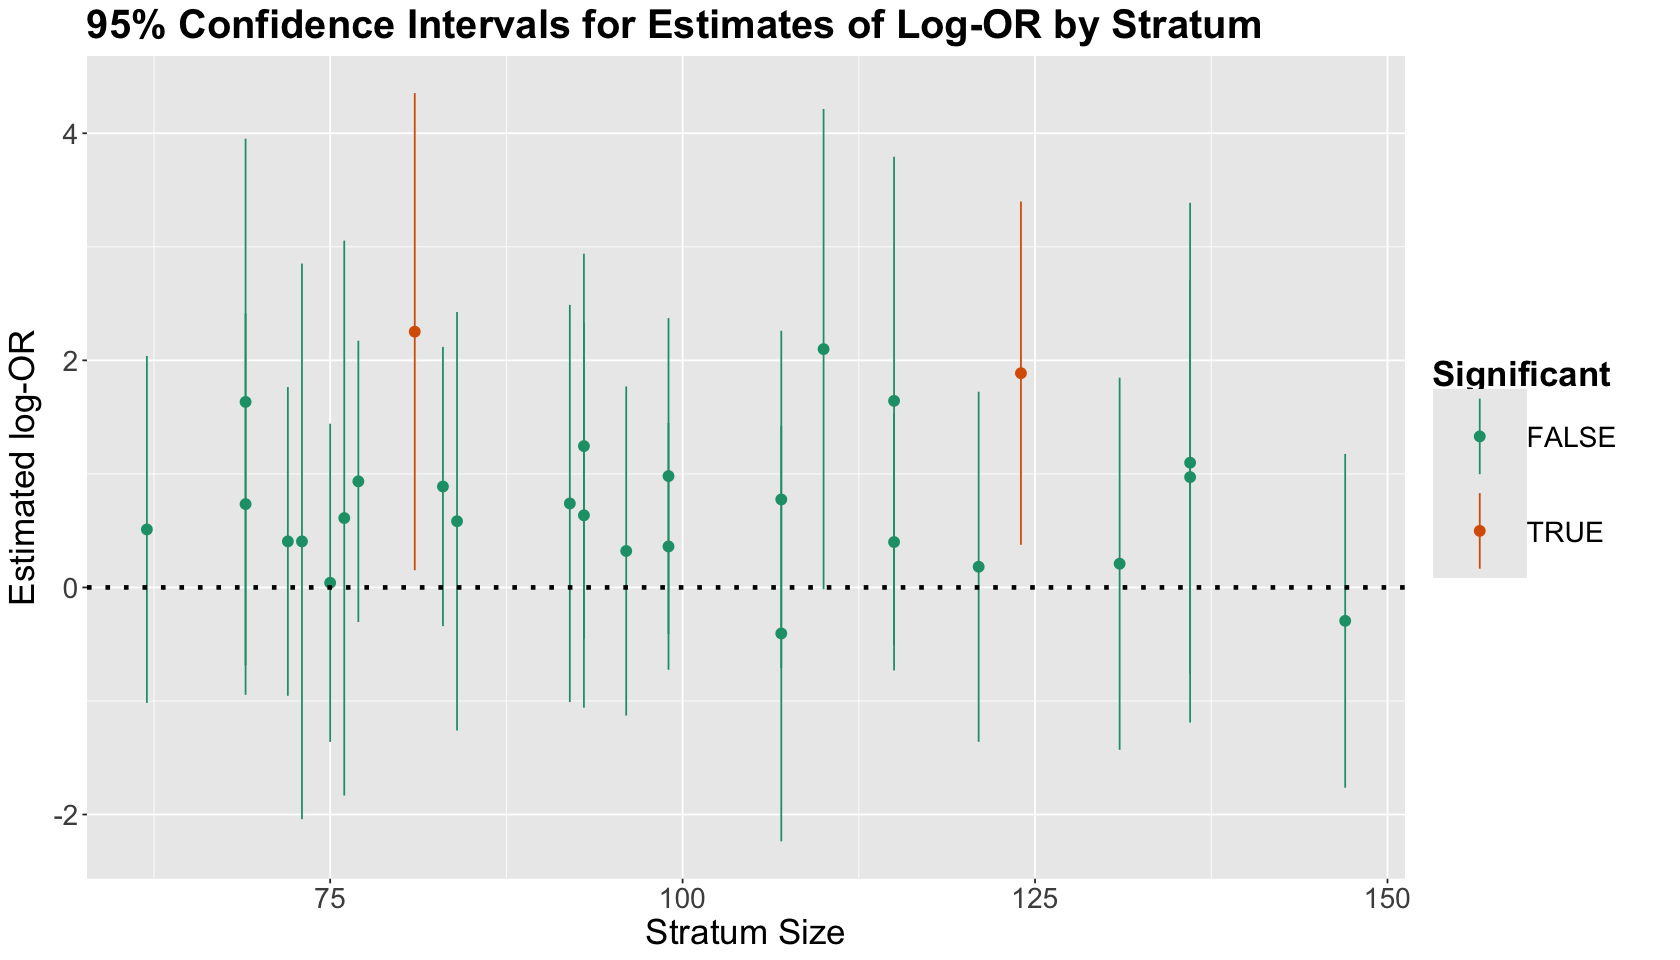

In [33]:
strata_log_OR_95_CI

```{admonition} What is the main takeaway from this CI plot?
:class: hint
Only two strata had significant results in terms of the estimated log-OR! Moreover, we can see some other strata were close to being significant (but not yet!).
```

```{exercise}
:label: lecture6-q3

Is there anything invalid from a statistical standpoint? Or, if it is not invalid, is there anything that we might want to do differently?
```

### 4.3. Causal Inference via an Overall Binomial Logistic Regression

The **overall Binomial Logistic regression** would be our more clever approach. It will include the binary variables $X$ and $Y$ **and the corresponding confounders $C_j$ AS STRATA**. This is our proxy for blocking in a randomized experiment! Note all regressors are modelled are **standalone variables**.

In [34]:
bin_log_model <-  glm(chd69 ~ dibpat + age_bins + bmi_bins + smoke, family = "binomial")
tidy(bin_log_model, conf.int = 0.95) %>% 
  mutate(exp.estimate = exp(estimate)) %>%
  mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,exp.estimate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-4.241,0.246,-17.215,0.000,-4.739,-3.772,0.014
dibpatType A,0.730,0.144,5.084,0.000,0.452,1.015,2.075
"age_bins(42,45]",0.190,0.230,0.826,0.409,-0.266,0.638,1.209
"age_bins(45,50]",0.687,0.197,3.483,0.000,0.304,1.079,1.989
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
"bmi_bins(23,24.4]",0.413,0.208,1.981,0.048,0.006,0.826,1.511
"bmi_bins(24.4,25.8]",0.569,0.205,2.778,0.005,0.171,0.975,1.766
"bmi_bins(25.8,38.9]",0.796,0.199,4.008,0.000,0.412,1.192,2.217
smokeYes,0.704,0.139,5.050,0.000,0.433,0.979,2.021


Using the same log-OR plot with the 95% CIs, we illustrate the 95% CI for the regression coefficient `estimate` `dibpatType A` (as dashed horizontal blue lines). The `estimate` corresponds to the solid horizontal blue line (**it is significant!**). If we compare this blue 95% CI with the other 26 95% CIs, we get a **more precise estimate** of $X$ with this overall Binomial Logistic regression model.

Waiting for profiling to be done...



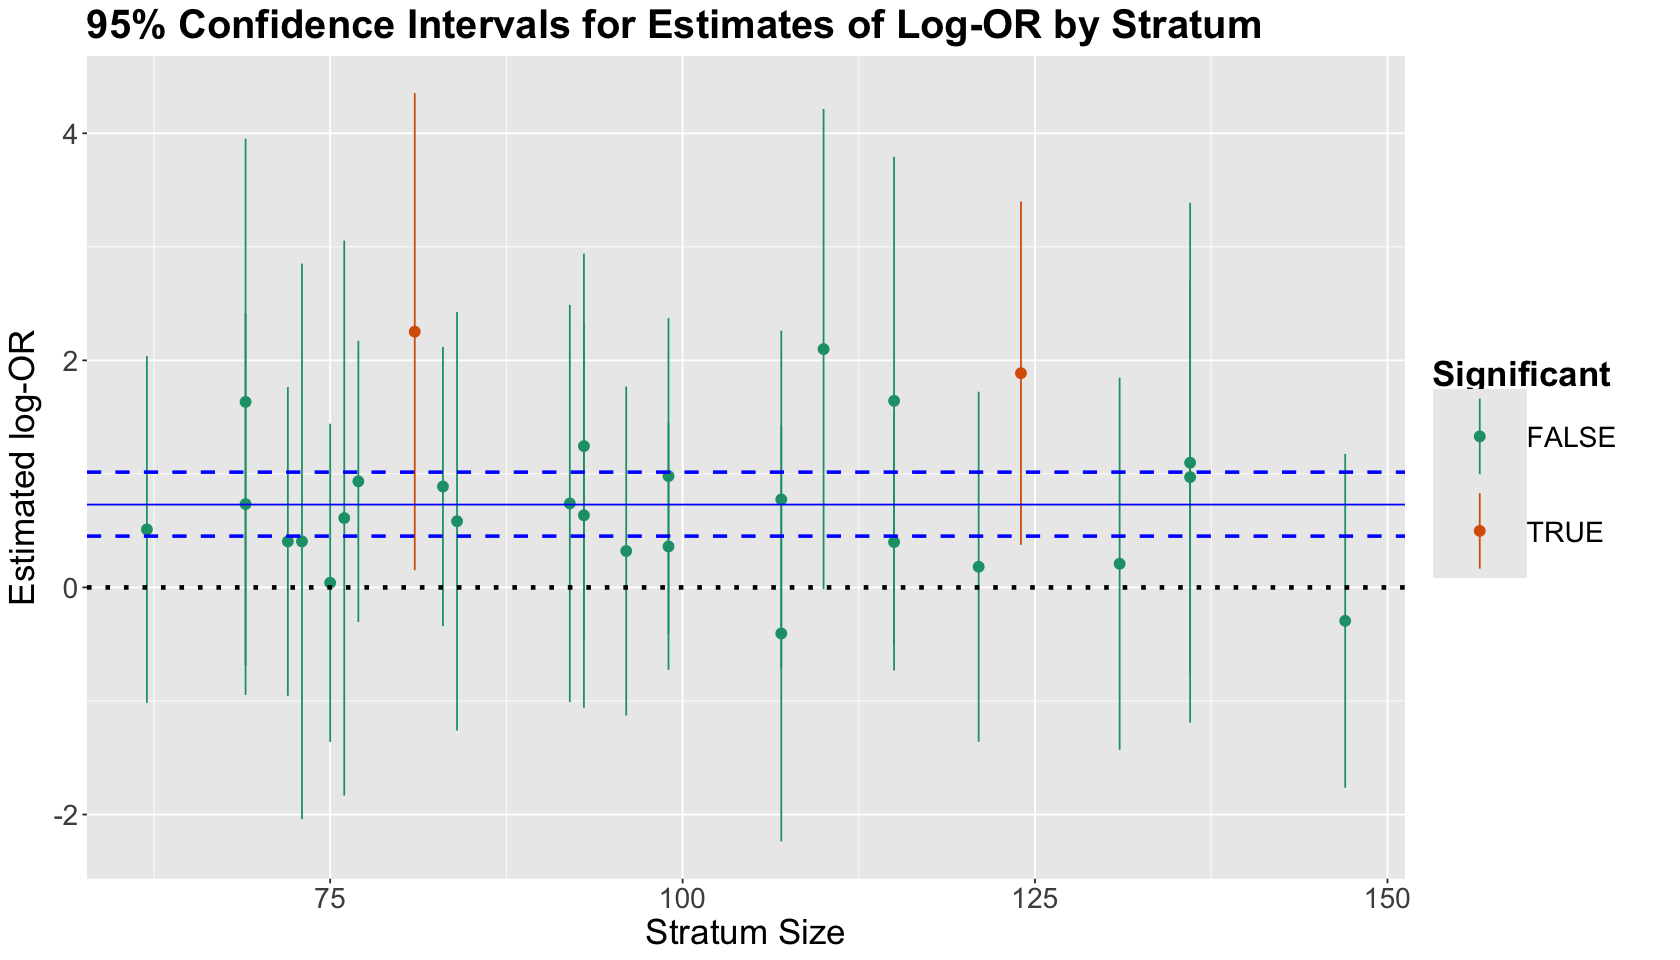

In [35]:
strata_log_OR_95_CI + geom_hline(yintercept = bin_log_model$coeff[2], colour = "blue") +
  geom_hline(yintercept = confint(bin_log_model)[2, ], linetype = "dashed", colour = "blue", linewidth = 1)

```{admonition} If we REALLY want to put a causal spin on our estimate for the $X$ coefficient, what must we assume?
:class: hint
By controlling for possible confounders such as age, BMI, and smoking status in our regression model; we are assuming that no matter what age, smoking status, or BMI this population of interest has, all subjects have the same effect of $X$ over $Y$:

> *Being a middle-aged man between the ages of 39 and 59 (and an employee of a Californian company) **with a `Type A` behaviour (when compared to `Type B`)** LEADS to being 2.075 times more likely to experience a CHD event.*
```

However, **unlike a stratum-specific inference with multiple confounders**, this class of causal conclusions must take various **assumptions** into account. Hence, bearing in mind that we fit

```
glm(chd69 ~ dibpat + age_bins + bmi_bins + smoke, family = "binomial")
```

we will explore these assumptions.

### 4.4. Assumptions for the Causal Overall Binomial Logistic Regression

The big idea of our `bin_log_model` is that this model is enough to assess causality of $X$ on $Y$. Nevertheless, this idea involves the following strong assumptions:

1. There is a **simple/smooth structure** in how the $Y$-specific log-OR varies across the strata.
2. The strength of the $(X, Y)$ association within each of the 32 strata defined by the confounders is the same (i.e., we **DO NOT HAVE** any double interactions between $X$ and each confounder).
3. This example assumes **we have included all of our confounding variables in our regression model**. Hence, there are only three for this model: age, smoking status, and BMI.

#### 4.4.1.  Stress test of the FIRST assumption (simple structure)

We will use **model selection** to assess this assumption. Since our `bin_log_model` is a maximum likelihood-based approach, we can the run a **likelihood ratio test (LRT)** to assess goodness of fit between two models: $\text{model 1}$ and $\text{model 2}$:

- $\text{model 1}$: It is a simpler model. This model is nested in $\text{model 2}$.
- $\text{model 2}$: It is a more complex model.

The hypotheses are:

```{math}
\begin{gather*}
H_0 \text{: model 1 fits the data better than model 2} \\
H_a \text{: otherwise}
\end{gather*}
```

For this assumption, the complex model will be one with **all possible interactions between the confounders up to the triple one**:

In [36]:
triple_bin_log_model <- glm(chd69 ~ dibpat + age_bins * bmi_bins * smoke, family = "binomial")
tidy(triple_bin_log_model) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-4.447,0.719,-6.183,0.000
dibpatType A,0.732,0.144,5.069,0.000
"age_bins(42,45]",-13.404,440.895,-0.030,0.976
"age_bins(45,50]",1.315,0.882,1.491,0.136
⋮,⋮,⋮,⋮,⋮
"age_bins(50,59]:bmi_bins(24.4,25.8]:smokeYes",-0.384,1.281,-0.300,0.764
"age_bins(42,45]:bmi_bins(25.8,38.9]:smokeYes",-13.273,440.896,-0.030,0.976
"age_bins(45,50]:bmi_bins(25.8,38.9]:smokeYes",1.387,1.292,1.074,0.283
"age_bins(50,59]:bmi_bins(25.8,38.9]:smokeYes",-0.109,1.250,-0.088,0.930


Note the estimate for `dibpatType A` is similar compared to `bin_log_model` (**both estimates and their standard errors are practically equal!**):

In [37]:
tidy(bin_log_model) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-4.241,0.246,-17.215,0.000
dibpatType A,0.730,0.144,5.084,0.000
"age_bins(42,45]",0.190,0.230,0.826,0.409
"age_bins(45,50]",0.687,0.197,3.483,0.000
⋮,⋮,⋮,⋮,⋮
"bmi_bins(23,24.4]",0.413,0.208,1.981,0.048
"bmi_bins(24.4,25.8]",0.569,0.205,2.778,0.005
"bmi_bins(25.8,38.9]",0.796,0.199,4.008,0.000
smokeYes,0.704,0.139,5.050,0.000


Then, we use the function `anova()` with the parameter `test = "LRT"`. Note that we will be storing different $p$-values in vector `p_values`.

In [38]:
anova(bin_log_model, triple_bin_log_model, test = "LRT")  %>% mutate_if(is.numeric, round, 3)
p_values <- c(anova(bin_log_model, triple_bin_log_model, test = "LRT")$`Pr(>Chi)`[2]) # Storing p-value

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3092,1628.780,NA,NA,NA
2,3068,1599.836,24,28.944,0.222


Given the $p$-value above for the LRT, our simple model suffices.

#### 4.4.2. Stress tests of the SECOND assumption (no interactions between $X$ and the confounders)

For the second assumption, we will fit three other models. Each of them will include the terms of our simple model `bin_log_model` plus one double interaction between $X$ and a given confounder. Then, we run the corresponding LRT via `anova()`. Given the $p$-values below for the LRT, our simple model suffices.

In [39]:
int_bin_log_model <-  glm(chd69 ~ dibpat + smoke + age_bins + bmi_bins + dibpat:age_bins, family = "binomial")
anova(bin_log_model, int_bin_log_model, test = "LRT")  %>% mutate_if(is.numeric, round, 3)
p_values <- c(p_values, anova(bin_log_model, int_bin_log_model, test = "Chi")$`Pr(>Chi)`[2]) # Storing p-value

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3092,1628.780,NA,NA,NA
2,3089,1627.929,3,0.852,0.837


In [40]:
int_bin_log_model_2 <-  glm(chd69 ~ dibpat + smoke + age_bins + bmi_bins + dibpat:smoke, family = "binomial")
anova(bin_log_model, int_bin_log_model_2, test = "LRT") %>% mutate_if(is.numeric, round, 3)
p_values <- c(p_values, anova(bin_log_model, int_bin_log_model_2, test = "LRT")$`Pr(>Chi)`[2]) # Storing p-value

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3092,1628.780,NA,NA,NA
2,3091,1627.647,1,1.133,0.287


In [41]:
int_bin_log_model_3 <-  glm(chd69 ~ dibpat + smoke + age_bins + bmi_bins + dibpat:bmi_bins, family = "binomial")
anova(bin_log_model, int_bin_log_model_3, test = "LRT") %>% mutate_if(is.numeric, round, 3)
p_values <- c(p_values, anova(bin_log_model, int_bin_log_model_3, test = "LRT")$`Pr(>Chi)`[2]) # Storing p-value

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3092,1628.780,NA,NA,NA
2,3089,1627.111,3,1.67,0.644


#### 4.4.3. Stress test of the THIRD assumption (no additional confounders are necessary)

Suppose we want to use the subject's cholesterol levels (`chol`) as an additional confounder besides the three ones already included in the simple `bin_log_model`. We will create another quartile strata for `chol` and fit another model called `chol_bin_log_model`. Then we run the corresponding LRT.

In [42]:
detach(training_data)

training_data <- training_data %>%
  mutate(chol_bins = cut(chol, breaks = c(min(chol), quantile(chol, (1:3) / 4), max(chol)), include.lowest = TRUE))
levels(training_data$chol_bins)

[1] "[103,197]" "(197,223]" "(223,253]" "(253,645]"

In [43]:
attach(training_data)

chol_bin_log_model <- glm(chd69 ~ dibpat + age_bins + smoke + bmi_bins + chol_bins, family = "binomial")
anova(bin_log_model, chol_bin_log_model, test = "LRT") %>% mutate_if(is.numeric, round, 3)
p_values <- c(p_values, anova(bin_log_model, chol_bin_log_model, test = "LRT")$`Pr(>Chi)`[2]) # Storing p-value

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3092,1628.780,NA,NA,NA
2,3089,1580.257,3,48.523,0


Note that in this case, we reject $H_0$ in our LRT. Hence we need to consider `chol` in our logistic regression model! Therefore, `bin_log_model` **DOES NOT** fulfil this assumption.

Testing the third assumption is challenging when assessing causation in observational studies involving many different confounders, such as the WCGS case. Hence, we can think about a practical solution: **automating the model building process and selection (confounder by confounder) while testing the three assumptions**.

```{attention}
The above idea is a crucial part of your work as a Data Scientist when doing **model building and selection** in observational studies to detect causation. Moreover, **this process involves multiple testing**! Hence, you need to use the concepts of {doc}`lecture1_multiple_comparisons`. This is the reason we stored all the previous `p_values`.
```

In [44]:
adj_p_values <- matrix(data = p.adjust(p_values, method = "bonferroni"), nrow = 1, ncol = length(p_values))
adj_p_values

1,1,1,1,8.239119e-10


The last adjusted $p$-value from left to right involves the LRT of `bin_log_model` versus `chol_bin_log_model`. We would need to proceed with `chol_bin_log_model` and restart the model checking since the first assumption. Testing the third assumption will involve an additional confounder from `wcgs`.

## 5. Wrapping Up

We have the following parting thoughts for today:

- We have made a connection between **stratification** and **regression**.
- In some contexts, we build regression models with **prediction** as the main goal.
- In others (like today!), we build regression models with **explanation** as the main goal.
- For **causal** interpretations, various assumptions must be met. These assumptions are pretty strong!
- Some of them are testable/checkable (typically having to do with appropriate model specification issues like smoothness, lack of interactions between the variable of interest and confounders, etc.).
- We almost always have at least one **untestable** assumption, e.g., **no unobserved confounders**.